In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
import numpy as np
import time
from PIL import Image



Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')
directory = "/content/gdrive/My Drive/Colab Notebooks/NST"
os.chdir(directory)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
def imshow(image, title):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  plt.title(title)

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
		 'block5_conv1'
               ]

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.load_vgg(style_layers, content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    
  
  def load_vgg(self, style_layers, content_layers):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    layer_names = style_layers + content_layers
    outputs = [vgg.get_layer(name).output for name in layer_names]

    self.vgg = tf.keras.Model([vgg.input], outputs)
    
  def gram_matrix(self, input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    
    style_outputs = [self.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
class ImageGenerator():
  def __init__(self, content_image, style_image, style_weight, content_weight, extractor):
    self.extractor = extractor
    self.style_weight = style_weight
    self.content_weight = content_weight
    self.gen_targets(content_image, style_image)
    
  def gen_targets(self, content_image, style_image):
    self.target_content = self.extractor(tf.constant(content_image))['content']
    self.target_style = self.extractor(tf.constant(style_image))['style']
    
  def calc_loss(self, outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.target_style[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= self.style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.target_content[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= self.content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss
    
  @tf.function()
  def train_step(self, image):
    with tf.GradientTape() as tape:
      outputs = self.extractor(image)
      loss = self.calc_loss(outputs)

    grad = tape.gradient(loss, image)
    self.opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
    return loss
  
  def train(self, epochs, lr, save_dir):
    steps_per_epoch = 100

    generated_image = tf.Variable(content_image)
    self.opt = opt = tf.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)

    start = time.time()

    step = 0
    
    
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        loss = self.train_step(generated_image)
        print(".", end='')
      print('\n')
      tf.keras.backend.print_tensor(loss, message="Loss: ")
      imshow(generated_image.read_value(), "Train step: {}".format(step))
      plt.show()
      
    image_array = generated_image.read_value().numpy()*255
    image_array = np.squeeze(image_array.astype(int),0)

    save_img=Image.fromarray(image_array.astype('uint8'))
    save_img.save(save_dir)
    end = time.time()
    print("Total time: {:.1f}".format(end-start))

In [0]:
extractor = StyleContentModel(style_layers, content_layers)


In [0]:
content_dir = 'images/turtle.jpg'
style_dir = 'images/wave.jpg'
save_dir = 'images/wave_turtle.jpg'

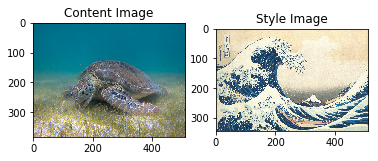

W0707 16:46:17.966558 139839565473664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


....................................................................................................

Loss:  21877098


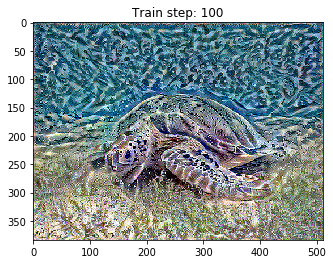

....................................................................................................

Loss:  11206427


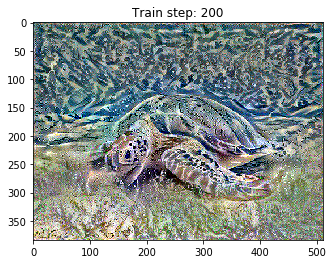

....................................................................................................

Loss:  7431832.5


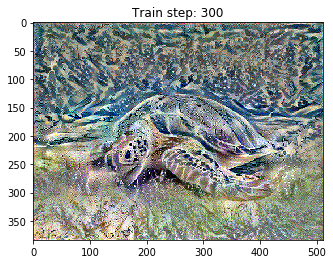

....................................................................................................

Loss:  5639267


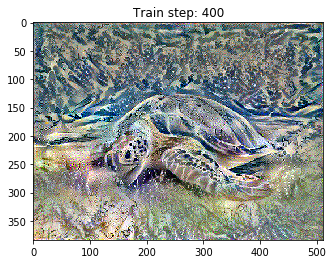

....................................................................................................

Loss:  4661705


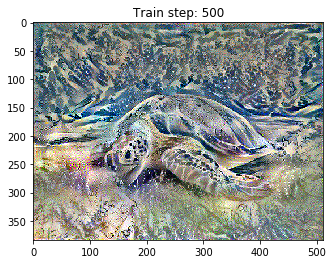

....................................................................................................

Loss:  4075869


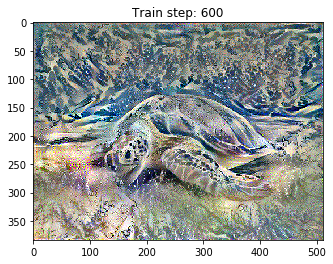

....................................................................................................

Loss:  3686555


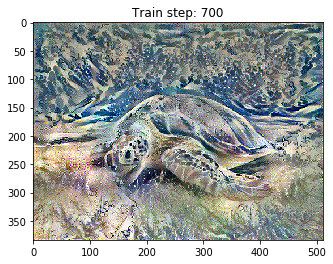

....................................................................................................

Loss:  3410249


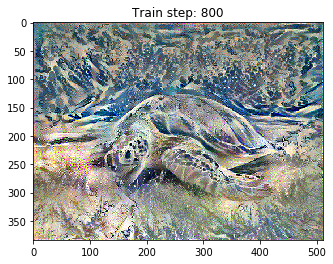

....................................................................................................

Loss:  3210397.25


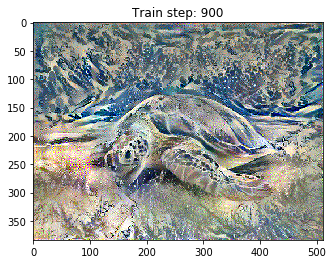

....................................................................................................

Loss:  3058346.5


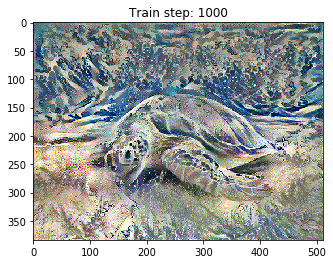

Total time: 79.4


In [11]:
content_image = load_img(content_dir)
style_image = load_img(style_dir)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.show()

gen = ImageGenerator(content_image, style_image, 1e-2,1e4, extractor)
gen.train(10, 0.02, save_dir)